In [1]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm
import glob
import pickle

import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

In [14]:
segmentation_train_dir="/home/ye/Data/Image/Indian-Diabetic/Segmentation/Groundtruths/training/"
original_train_dir="/home/ye/Data/Image/Indian-Diabetic/Segmentation/Original-Images/training/"

segmentation_val_dir="/home/ye/Data/Image/Indian-Diabetic/Segmentation/Groundtruths/testing/"
original_val_dir="/home/ye/Data/Image/Indian-Diabetic/Segmentation/Original-Images/testing//"
#images_list=glob.glob(DATA_DIR+"*.tif")

WORK_DIR="/home/ye/Project/Zoc/Python/DL_MODULE/Keras/Object-Dectect/Mask_RCNN/Indian-Diabetic/"
COCO_WEIGHTS_PATH="../mask_rcnn_coco.h5"
MODEL_PATH="checkpoints/train_512_5_layers/mask_rcnn_idrid_0020.h5"

height,width=2848,4288

In [3]:
sys.path.append("..")
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax



In [26]:
#import argparse

#parser=argparse.ArgumentParser("Parameters for Mask RCNN Model")
#parser.add_argument("--train",type=str,dest="train",default="./data/train-mask.pkl")
#parser.add_argument("--val",type=str,dest="validation",default="./data/val-mask.pkl")
#parser.add_argument("--pretrained",type=str,default="coco",choices=["coco","imagenet"])
#parser.add_argument("-m","--mode",type=str,dest="model",default="inferece",choices=["training","inference"])



In [6]:
with open("./data/train-mask.pkl","rb") as msk:
    train_mask=pickle.load(msk)
    
    
with open("./data/val-mask.pkl","rb") as msk:
    val_mask=pickle.load(msk)
    

### Some setup functions and classes for Mask-RCNN

In [7]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    NAME="IDRiD"
    
    GPU_COUNT=1
    IMAGES_PER_GPU=2
    
    BACKBONE="resnet50"
    
    NUM_CLASSES=1+5 # background +1 pneumonia classes
    IMAGE_MIN_DIM=512
    IMAGE_MAX_DIM=512
    #RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 512
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.01
    LEARNING_RATE=0.0001
    WEIGHT_DECAY=0.0007

    STEPS_PER_EPOCH =500


In [9]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self,image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        #self.add_class("IDRiD",0,"BG")
        self.add_class("IDRiD",1,"Haemorrhages")
        self.add_class("IDRiD",2,"SoftExudates")
        self.add_class("IDRiD",3,"HardExudates")
        self.add_class('IDRiD',4,"Microaneurysms")
        self.add_class("IDRiD",5,"OpticDisc")
        self.label_dict={"BG":0,"Haemorrhages":1,"SoftExudates":2,"HardExudates":3,"Microaneurysms":4,"OpticDisc":5}
        
        # add images 
        for i, fp in enumerate(image_annotations):
            classes = fp["classes"]
            path=fp["path"]
            mask=fp["mask"]
            self.add_image('IDRiD', image_id=i, path=path, mask=mask,
                           classes=classes, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        assert image_id in self.image_ids
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        image=cv2.imread(fp)
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        count=info["mask"].shape[-1]
        classes=info["classes"]  # consistent with mask
        
        class_ids = np.zeros((count), dtype=np.int32)
        #class_ids = np.array([self.class_names.index(s[0]) for s in classes])
        msk=info["mask"]
        for i,c in enumerate(classes):
            class_ids[i]=self.label_dict[c]
        return msk.astype(np.bool), class_ids
 

In [10]:
dataset_train=DetectorDataset(image_annotations=train_mask,orig_height=height,orig_width=width)
dataset_train.prepare()

dataset_val=DetectorDataset(image_annotations=val_mask,orig_height=height,orig_width=width)
dataset_val.prepare()

image_id  8 /home/ye/Data/Image/Indian-Diabetic/Segmentation/Original-Images/testing//IDRiD_63.jpg
image                    shape: (2848, 4288, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (2848, 4288, 4)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (4,)                  min:    1.00000  max:    5.00000  int32
bbox                     shape: (4, 4)                min:   74.00000  max: 3615.00000  int32


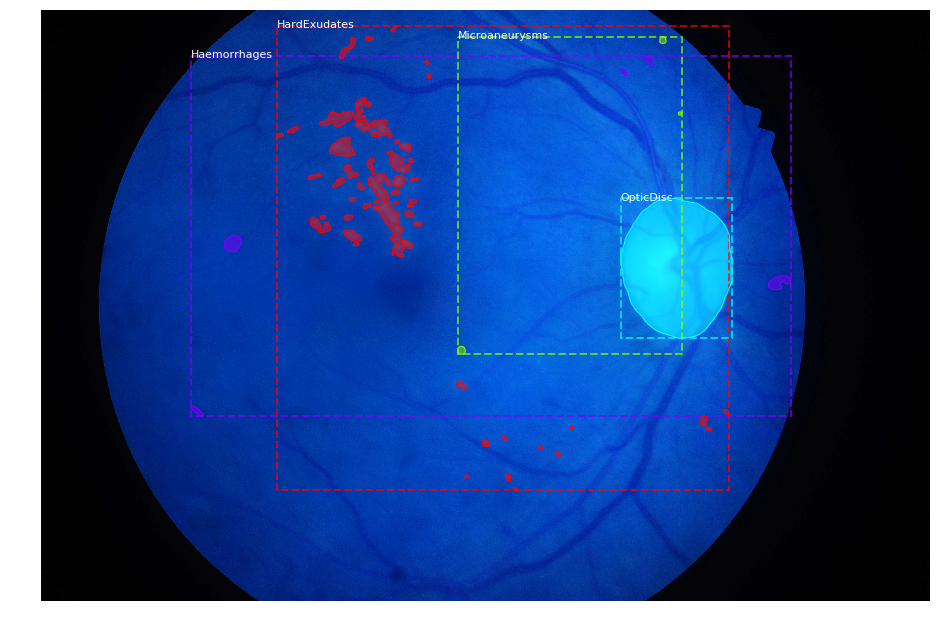

In [11]:
image_id = random.choice(dataset_val.image_ids)
image = dataset_val.load_image(image_id)
msk, class_ids = dataset_val.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(msk)

# Display image and additional stats
print("image_id ", image_id, dataset_val.image_reference(image_id))
log("image", image)
log("mask", msk)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, msk, class_ids, dataset_val.class_names)

(2848, 4288, 3)
[1 3 4 5]


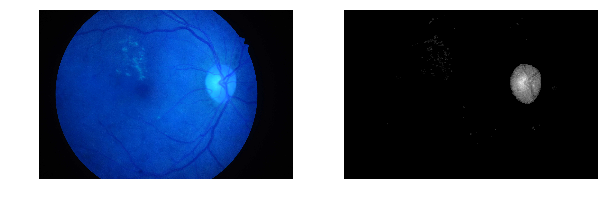

In [12]:
print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(msk.shape[2]):
    masked += image[:, :, 0] * msk[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(class_ids)

#### training the model

#### Detection

In [15]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    BACKBONE="resnet50"

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=WORK_DIR)

#MODEL_PATH="../mask_rcnn_imagenet.h5"
#MODEL_PATH="./checkpoints/mask_rcnn_idrid_101-0050.h5"
# Load trained weights
print("Loading weights from ",MODEL_PATH)
model.load_weights(MODEL_PATH, by_name=True)

Loading weights from  checkpoints/train_512_5_layers/mask_rcnn_idrid_0020.h5


original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (18,)                 min:    0.00000  max: 4288.00000  float64
gt_class_id              shape: (4,)                  min:    1.00000  max:    5.00000  int32
gt_bbox                  shape: (4, 4)                min:   79.00000  max:  428.00000  int32
gt_mask                  shape: (512, 512, 4)         min:    0.00000  max:    1.00000  bool


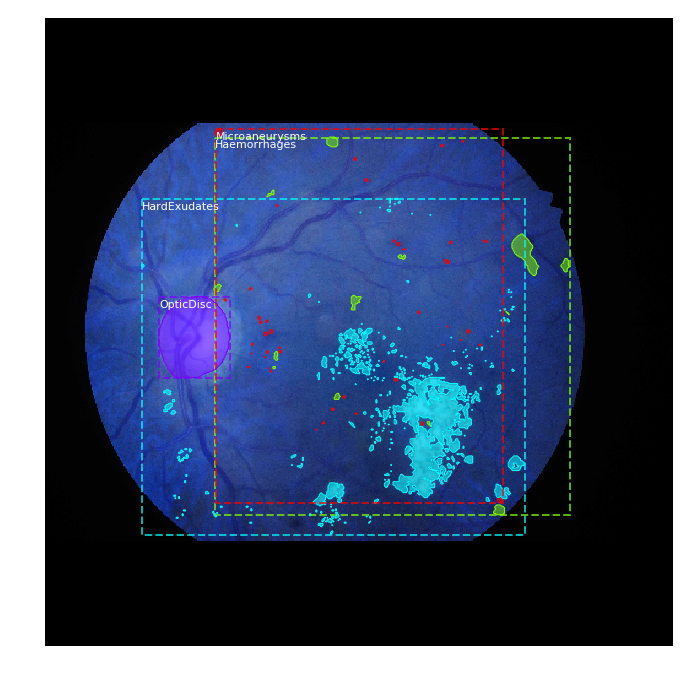

In [16]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(12, 12))

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


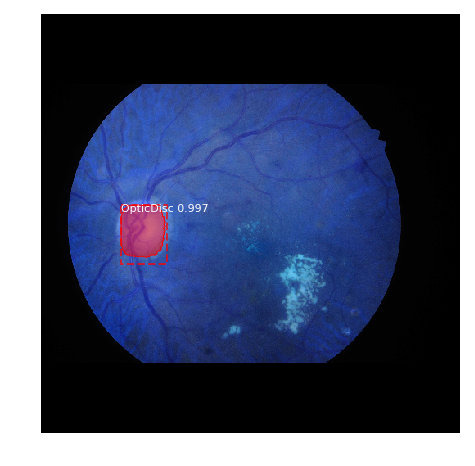

In [17]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())


In [18]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.22000000178813933
